In [1]:
class PARAMS:
    # 只选择 2 年的数据对未来俩日进行预测
    ndays = 365 * 2
    use_optuna = False
    nfold = 5
    # feature构造使用的历史最大天数
    maxday = 120
    kaggle_path = ''
    colab_path = '/content/'
    local_update_path = '/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/code_JPX/data_preprocess/data_output/'
    local_origin_path = '/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/train_files/'
    is_preprocess = True
    random_seed = 1128
    where_code = 'Local'
    

# Import Pacakge

In [2]:

import optuna
import pandas as pd
import numpy as np

import lightgbm as lgb
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _BaseKFold
from sklearn.model_selection import TimeSeriesSplit

import joblib
import os
import gc

import matplotlib.pyplot as plt
import plotly.express as px

import wandb
from wandb.lightgbm import wandb_callback, log_summary

from optuna.integration import LightGBMPruningCallback
from optuna.visualization import plot_contour
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
import warnings
warnings.filterwarnings("ignore")


## Wandb Tracking 

In [3]:
wandb.login()

wandb: Currently logged in as: dylanli (use `wandb login --relogin` to force relogin)


True

In [4]:
wandb.init(project="JPX_lgb", reinit = True)


# Colab Part

In [5]:
if PARAMS.where_code == 'Colab':
    if os.path.exists(PARAMS.colab_path + 'jpx-tokyo-stock-exchange-prediction.zip'):
        ! mkdir ~/.kaggle
        ! cp /content/drive/MyDrive/JPX_Competition/kaggle.json ~/.kaggle/
        ! chmod 600 ~/.kaggle/kaggle.json
        ! kaggle competitions download -c jpx-tokyo-stock-exchange-prediction
        ! unzip -q /content/jpx-tokyo-stock-exchange-prediction.zip -d /content/
        
    print("============查看GPU信息================")
    # 查看GPU信息
    !/opt/bin/nvidia-smi
    print("==============查看Tensorflow版本==============")
    # 查看Tensorflow版本
    import tensorflow as tf
    print(tf.__version__)
    print("============查看虚拟机硬盘容量================")
    # 查看虚拟机硬盘容量
    !df -lh
    print("============查看cpu配置================")
    # 查看cpu配置
    !cat /proc/cpuinfo | grep model\ name
    print("=============查看内存容量===============")
    # 查看内存容量
    !cat /proc/meminfo | grep MemTotal


## Feature and preprocess funtion

In [6]:
# calculate factors functions
def returnMAE(df, n):
    df[f'average{n}'] = df.Close.rolling(window=n, min_periods=1).mean()
    return df


def returnEWM(df,n=12):
    df[f'average{n}'] = df.Close.ewm(span=n, min_periods=1).mean()
    return df

def returnBoll(df,n=20):
    mean = df.Close.rolling(window=n, min_periods=1).mean()
    std = df.Close.rolling(window=n, min_periods=1).std()
    bl1 = mean+2*std
    bl2 = mean-2*std
    df[f'bollDown'] = bl1 
    df[f'bollUp'] = bl2
    return df

def returnMAEVolume(df, n=12):
    df[f'MAEVolume_{n}'] = df.Volume.rolling(window=n, min_periods=1).mean()    
    return df

def returnSTDVolume(df, n=10):
    df[f'STDVolume_{n}'] = df.Volume.rolling(window=n, min_periods=1).std()
    return df

def calUpNumber(x):
    x = x.diff()
    return x[x > 0].count()
        
def returnUpDate(df, n=13):
    number = df.Volume.rolling(window=n, min_periods=1).apply(calUpNumber)
    df['UpDate'] = number/12
    return df

def returnWillingness(df, n=26):
    df1 = df
    df1['diff1'] = df1.High - df1.Close.shift(1)
    df1['diff2'] = df1.Close.shift(1) - df1.Low
    sum1 = df1.diff1.rolling(window=n, min_periods=1).sum()
    sum2 = df1.diff2.rolling(window=n, min_periods=1).sum()
    will = sum1/sum2
    df['Willness'] = will
    df.drop(['diff1', 'diff2'], axis=1, inplace=True)
    return df

## apply features function
def applyFactors(df):
    df['money_flow'] = (df.Close + df.High + df.Low)/3 * df.Volume
    df = returnMAE(df, 5) 
    df = returnMAE(df, 10) 
    df = returnMAE(df, 20) 
    df = returnMAE(df, 60) 
    df = returnMAE(df, 120) 
    df = returnBoll(df,n=20)
    df = returnEWM(df,n=10)
    df = returnUpDate(df)
    df = returnMAEVolume(df)
    df = returnSTDVolume(df)
    df = returnSTDVolume(df, 20)
    df = returnWillingness(df)
    return df

# data preprocess 3 sigma rule (不一定有效的方法)
def calculateOutlier(column):
    mu = column.mean()
    std = column.std()
    outlier = column[np.abs(column - mu) > 3*std]
    if pd.isnull(outlier.any()):
        return column
    else:
        column.clip(lower=mu - 3*std, upper=mu + 3*std)
        
# StandardScaler 神经网络训练适用
def applyStandN(df):
    df_ = pd.DataFrame(columns = df.columns)

    for id in df.SecuritiesCode.unique():
        std_data = df
        ss = StandardScaler()
        std_data.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']] = ss.fit_transform(std_data.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']])
        std_data.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']].apply(calculateOutlier, axis=0)
        price_std = pd.concat([df_,std_data])
        df_ = price_std
        
    return df

# reduce memory usage
def reduce_mem_usage(df, verbose=True):
    ''' 
    reduce every columns mem useage 
    change the dtype of it 
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
# sharp_ratio 评估函数
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short
    
    df.reset_index(inplace=True, drop=True)
    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    # print(buf)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

## Data Load 

In [8]:
if PARAMS.is_preprocess and PARAMS.where_code == 'Local':
    df = pd.read_csv(PARAMS.local_update_path + 'prices_update.csv' )
    df = df.drop(df.columns[0:2], axis=1)
elif not PARAMS.is_preprocess and PARAMS.where_code == 'Local':
    df = pd.read_csv(PARAMS.local_origin_path + 'stock_prices.csv')
    df = reduce_mem_usage(df)
    df = df.groupby('SecuritiesCode').apply(applyFactors)
elif PARAMS.where_code == 'Kaggle':
    df = pd.read_csv(PARAMS.colab_path + 'stock_prices.csv')
    df = reduce_mem_usage(df)
    df = df.groupby('SecuritiesCode').apply(applyFactors)
elif PARAMS.where_code == 'Colab':
    df = pd.read_csv(PARAMS.kaggle_path + 'stock_prices.csv')
    df = reduce_mem_usage(df)
    df = df.groupby('SecuritiesCode').apply(applyFactors)

### deal Null

In [9]:
%%time

df.Date = pd.to_datetime(df.Date)
df['Date'] = df['Date'].dt.strftime("%Y%m%d").astype(int)
SecuritiesCode = np.sort(df.SecuritiesCode.unique())
df = df.sort_values(by=['Date', 'SecuritiesCode'])
df = df.fillna(method = 'pad')



CPU times: user 6.25 s, sys: 251 ms, total: 6.5 s
Wall time: 6.49 s


## Preprocess 

In [10]:
from decimal import ROUND_HALF_UP, Decimal
def adjust_price(price):
    """
    We will generate AdjustedClose using AdjustmentFactor value. 
    This should reduce historical price gap caused by split/reverse-split.
    
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        
        # generate AdjustedClose
        df.loc[:, "Close"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["Close"] == 0, "Close"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "Close"] = df.loc[:, "Close"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index(['Date'], inplace=True)
    return price

In [11]:
%%time
df = adjust_price(df)

CPU times: user 4.16 s, sys: 572 ms, total: 4.73 s
Wall time: 4.79 s


In [12]:
stock_price_data = df
df = df.reset_index()

In [13]:
df.drop('CumulativeAdjustmentFactor', inplace=True, axis=1)

In [14]:
features = ['Open', 'Close', 'High', 'Low', 'SecuritiesCode' ] + df.columns.to_list()[12:]

## Cross Validation 

In [15]:
def setup_cv(df, splits=PARAMS.nfold):
    df['fold'] = -1
    
    gcv = TimeSeriesSplit(n_splits=splits)
    for index , (t_, v_) in enumerate(gcv.split(df, groups = df.index)):
        print(f"{'=' * 20} val_{index} {'=' * 20}")
        print(v_)
        df.iloc[v_, -1] = index
    
    return df

In [16]:
df = setup_cv(df)

==================== val_0 ====================
[387488 387489 387490 ... 774972 774973 774974]
==================== val_1 ====================
[ 774975  774976  774977 ... 1162459 1162460 1162461]
==================== val_2 ====================
[1162462 1162463 1162464 ... 1549946 1549947 1549948]
==================== val_3 ====================
[1549949 1549950 1549951 ... 1937433 1937434 1937435]
==================== val_4 ====================
[1937436 1937437 1937438 ... 2324920 2324921 2324922]


In [17]:
df.fold.unique()

array([-1,  0,  1,  2,  3,  4])

## Optuna with Cross Validation

In [18]:
def Objective(trial, df, fold):
    params_grid = {
        'objective' : 'regression',
        'metric':'rmse',
        'seed' : PARAMS.random_seed,
        'num_leaves': trial.suggest_int('num_leaves', 300, 4000 ),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
        'max_bin': trial.suggest_int('max_bin', 2, 100),
        'learning_rate': 0.1,
    }
    
    cv_scores = np.empty(fold)
    
    for i in range(fold):
        train_index = df[df.fold != i].index
        val_index = df[df.fold == i].index
        
        train_x = df.iloc[train_index, :][features]
        train_y = df.iloc[train_index, :]['Target']
        
        val_x = df.iloc[val_index, :][features]
        val_y = df.iloc[val_index, :]['Target']
        
        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_val = lgb.Dataset(val_x, val_y)
        model_optuna = lgb.train(params_grid, train_set=lgb_train, valid_sets=lgb_val, verbose_eval=False, early_stopping_rounds=100, callbacks=[LightGBMPruningCallback(trial, 'rmse')])
        
        pred = model_optuna.predict(val_x)
        cv_scores[i] = np.sqrt(mean_squared_error(val_y, pred))
        del train_x, train_y
        gc.collect()
        
    return np.mean(cv_scores)

In [19]:

def optuna(use):
    best_params = {}
    if use:
        file_path = '/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/code_JPX /model/LightGBM_params'
        list = os.listdir(file_path)
        n = len(list)
        if list:
            list.sort(key=lambda fn:os.path.getmtime(file_path+"\\"+fn))
            file_new = list[-1]
            best_params = np.load(file_new, allow_pickle=True).item()
            
        study = optuna.create_study(direction='minimize', study_name='LGBM Regression')
        func = lambda trial : Objective(best_params, trial, x, y,)
        study.optimize(func, n_trials=50)
        
        best_params = dict(study.best_params.items())
        best_params['random_seed'] = 16 # set for test 
        np.save(f'/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/code_JPX /model/LightGBM_params/LGBM_optuna_{n}', best_params)
    else: 
        pass
    return best_params
    

## LGBM Model

USE THIS MODEL to predict and score

In [20]:
def set_rank(df):
    df = df.sort_values("predict", ascending=False)
    df.loc[:, "Rank"] = np.arange(len(df.predict))
    return df

In [32]:
def light_gbm(params,df, fold):
    params_grid = {
            'objective' : 'regression',
            'metric':'rmse',
            'learning_rate': 0.1,
            'n_estimators': 200,
            'min_child_weight' : 1,
            **params, #重复则选用 params 中的参数
        }
    wandb.config.update(params_grid)
    
    models = list()
    feature_importants = list()
    scores = list()
    evals_result = {}
    
    for f in range(fold):
        print(f"{'=' * 20} fold {f} {'=' * 20}")
        
        train_index = df[df.fold != f].index
        val_index = df[df.fold == f].index
        train_x = df.iloc[train_index, :][features]
        train_y = df.iloc[train_index, :]['Target']
        
        val_x = df.iloc[val_index, :][features]
        val_y = df.iloc[val_index, :]['Target']
        
        callbacks = wandb_callback()
        
        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_val = lgb.Dataset(val_x, val_y)
        model_lightgbm = lgb.train(params_grid, train_set=lgb_train, valid_sets=[lgb_train,lgb_val], evals_result=evals_result ,verbose_eval=False, early_stopping_rounds=100, callbacks=[callbacks])
        model_lightgbm.save_model(f'/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/code_JPX/model/LightGBM_model/LGBM_model_{f}.txt')
        print(f"{'=' * 20} fold {f} diagram {'=' * 20}")
        ax = lgb.plot_metric(evals_result, metric='rmse')
        plt.show()
        ax = lgb.plot_importance(model_lightgbm, max_num_features=8)
        plt.show()
        
        models.append(model_lightgbm)
        print('Save model corectly')
        
        feature_importants.append(model_lightgbm.feature_importance())
        
        off_pred = model_lightgbm.predict(val_x)
        off_score = np.sqrt(mean_squared_error(val_y, off_pred))
        print(f"Off-line RMSE: {off_score}")
        
        results = df.iloc[val_index, :]
        results['predict'] = off_pred
        results['Target'] = val_y
        results = results.sort_values(by=['Date', 'predict'], ascending=[True, False], inplace=False)
        results = results.groupby(by=['Date']).apply(set_rank)
        
        sharpe_scores = calc_spread_return_sharpe(results)
        scores.append(sharpe_scores)
        print('Validation sharpe = {:.4f}'.format(sharpe_scores))
        
        del train_x, train_y, val_x, val_y
        gc.collect()
    #Wandb Tracking 
    for score in scores:
        wandb.log({'Validation sharpe': score})
    return  models, feature_importants, scores, evals_result

In [25]:
## NN 模型

In [31]:
!wandb agent dylanli/JPX_l;lgb/uiomllbj

wandb: Starting wandb agent 🕵️
wandb: ERROR Error while calling W&B API: entityName required for project query (<Response [400]>)
wandb: ERROR Find detailed error logs at: /Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/code_JPX/model/wandb/debug-cli.log
Error: <Response [400]>
zsh:1: no such file or directory: lgb/uiomllbj


==================== fold 0 ====================
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4346
[LightGBM] [Info] Number of data points in the train set: 1937436, number of used features: 18
[LightGBM] [Info] Start training from score 0.000379
==================== fold 0 diagram ====================


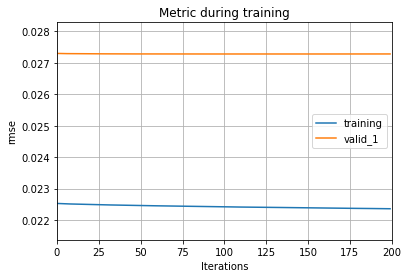

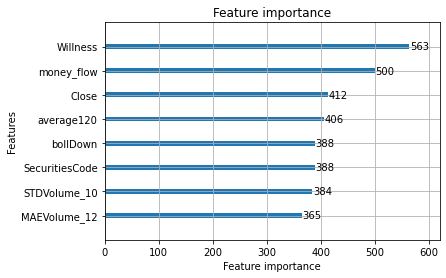

Save model corectly
Off-line RMSE: 0.027284596407932658
Validation sharpe = nan
==================== fold 1 ====================
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4346
[LightGBM] [Info] Number of data points in the train set: 1937436, number of used features: 18
[LightGBM] [Info] Start training from score 0.000413
==================== fold 1 diagram ====================


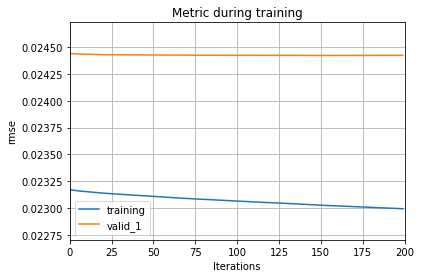

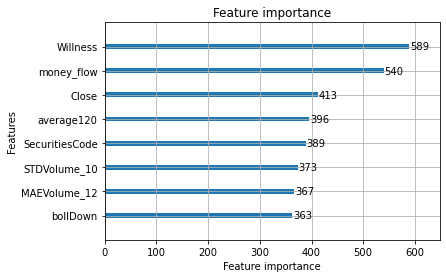

Save model corectly
Off-line RMSE: 0.024423185856030736
Validation sharpe = nan
==================== fold 2 ====================
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 1937436, number of used features: 18
[LightGBM] [Info] Start training from score 0.000409
==================== fold 2 diagram ====================


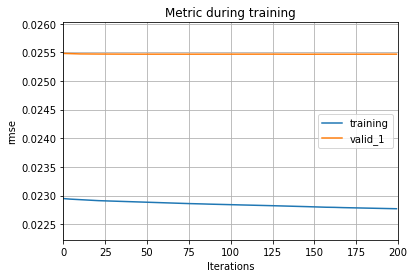

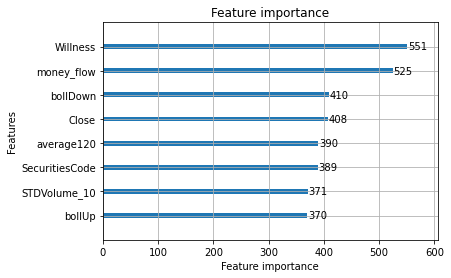

Save model corectly
Off-line RMSE: 0.025467960930043717
Validation sharpe = nan
==================== fold 3 ====================
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 1937436, number of used features: 18
[LightGBM] [Info] Start training from score 0.000462
==================== fold 3 diagram ====================


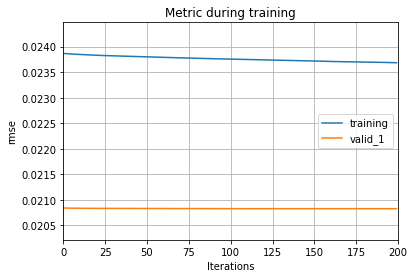

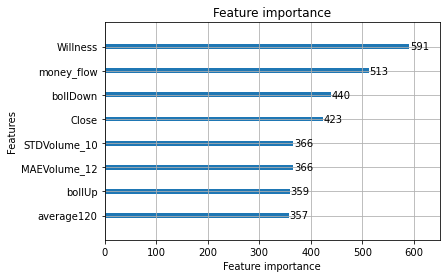

Save model corectly
Off-line RMSE: 0.020823918453613387
Validation sharpe = nan
==================== fold 4 ====================
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 1937436, number of used features: 18
[LightGBM] [Info] Start training from score 0.000459
==================== fold 4 diagram ====================


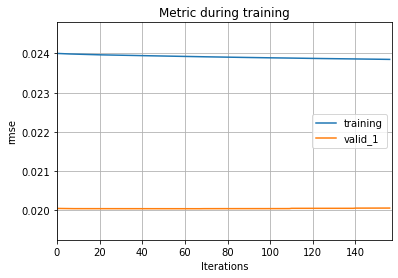

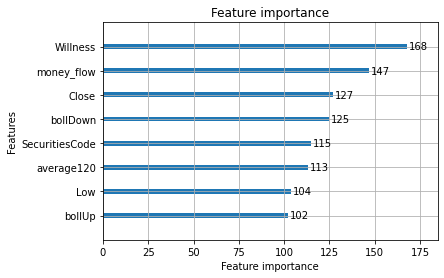

Save model corectly
Off-line RMSE: 0.02004312070660689
Validation sharpe = nan
CPU times: user 2min 28s, sys: 43.6 s, total: 3min 12s
Wall time: 1min 11s


In [33]:
%%time
## 使用 Optuna 
best_params = optuna(PARAMS.use_optuna)

## 返回LGBM模型并评估
models, feature_importants, scores, evals_result= light_gbm(best_params, df, PARAMS.nfold)

# Wandb


## 返回 NN 模型并评估

## 评估未来 sharp ratio

{'training': OrderedDict([('rmse',
               [0.024001297773829745,
                0.0239985406371262,
                0.023996224944729944,
                0.02399355459366811,
                0.023991362651931882,
                0.02398957876829682,
                0.023987567254201616,
                0.023985832766480947,
                0.02398423226398435,
                0.023982534880105,
                0.023980556204322198,
                0.0239789353777289,
                0.023976971529652384,
                0.02397572595342582,
                0.023974257503037662,
                0.02397274555123121,
                0.023971234290160504,
                0.023969285730091338,
                0.023967942686611177,
                0.023966977325781857,
                0.02396585017317893,
                0.02396459420510575,
                0.02396355596515954,
                0.023962386911390583,
                0.02396109042052674,
                0.0239602649243

In [60]:
# 一个函数, 用于在时间序列 API 制作 feature 进行评估

def make_predict_feature(prediction, origin):
    prediction = prediction.copy()
    origin = origin.copy()
    min_date = prediction.Date.min()
    df_l = origin[origin.Date < min_date]
    df_cal = pd.concat([df_l, prediction], axis=0, ignore_index=True).groupby('SecurityCode').apply(applyFactors).reset_index(drop=True)
    df_  = df_cal[df_cal.Date > min_date]
    return df_cal
    
    
    

In [281]:
test = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv')
df_ = pd.DataFrame(columns=test.columns)
for id in test.SecuritiesCode.unique():
    df = test[test.SecuritiesCode == id]
    df['shift1'] = test.Close.shift(-1)
    df['shift2'] = test.Close.shift(-2)
    target = (df.shift2 - df.shift1)/df.shift1
    df['Target'] = target
    df_ = pd.concat([df_,df])



In [282]:
df_.reset_index(drop=True, inplace=True)

In [283]:
test = df_
test = test[test.Date < '2021-12-08']
indices = test.index.size
test.Date = pd.to_datetime(test.Date)
test['Date'] = test['Date'].dt.strftime("%Y%m%d").astype(int)


In [284]:
df2 = pd.concat([stock_price_data.iloc[- MAXDAY * 2000: ], test], ignore_index=True)

In [285]:
df2 = applyFactors(df2)

In [286]:
test_ = df2.iloc[-4000:, :]

In [287]:
test_.reset_index(drop=True, inplace=True)

In [300]:
test_[['SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target', 'money_flow']] = test_[['SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target', 'money_flow']].astype('float')

In [301]:
pre = list()
for i in range(NFOLD):
    model = lgb.Booster(model_file=f'/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/code_JPX /model/LightGBM_model/LGBM_model_{i}.txt')
    pred = model.predict(test_[features], num_iteration=model.best_iteration)
    pre.append(pred)
    print(pre)
    break
pred_ = np.mean(pre,axis=0)

[array([ 0.00445945,  0.00451724,  0.00248187, ..., -0.00031713,
        0.00446743,  0.00431833])]


In [310]:
test_.sort_values(by=['Date', 'SecuritiesCode'], inplace=True)

In [311]:
test_

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,bollUp,NumberUp_12,MAEVolume_12,STDVolume_10,STDVolume_20,Willness,shift1,shift2,EWM_10,Prediction
0,20211206_1301,20211206,1301.0,2982.0,2982.0,2965.0,2971.0,8900.0,1.0,NaN,...,3142.772820,6.0,1.154167e+04,4376.249028,4117.050554,1.246801,589.0,2377.0,2974.114911,0.004459
2,20211206_1332,20211206,1332.0,592.0,599.0,588.0,589.0,1360800.0,1.0,NaN,...,637.522261,7.0,1.444392e+06,536225.376435,745493.019117,0.954315,2377.0,1224.0,585.916075,0.002482
4,20211206_1333,20211206,1333.0,2368.0,2388.0,2360.0,2377.0,125900.0,1.0,NaN,...,2534.414054,4.0,1.281833e+05,36966.585512,59670.686403,0.642055,1224.0,1351.0,2346.094098,0.004829
6,20211206_1375,20211206,1375.0,1230.0,1239.0,1224.0,1224.0,81100.0,1.0,NaN,...,1452.424429,6.0,1.211500e+05,44091.072415,38942.176770,0.455782,1351.0,3200.0,1257.444191,0.003073
8,20211206_1376,20211206,1376.0,1339.0,1372.0,1339.0,1351.0,6200.0,1.0,NaN,...,1499.678748,2.0,5.100000e+03,2406.565095,2411.682095,0.761557,3200.0,1889.0,1369.342953,0.004034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,20211207_9990,20211207,9990.0,526.0,535.0,524.0,535.0,57800.0,1.0,NaN,...,612.952175,6.0,5.948333e+04,25536.903580,25294.419501,1.268293,805.0,1620.0,533.334239,0.003595
3993,20211207_9991,20211207,9991.0,795.0,806.0,792.0,805.0,48500.0,1.0,NaN,...,834.216814,6.0,3.646667e+04,18767.335690,13907.373092,1.250000,1620.0,2440.0,791.977915,0.003813
3995,20211207_9993,20211207,9993.0,1640.0,1640.0,1620.0,1620.0,6600.0,1.0,NaN,...,1768.531442,4.0,5.483333e+03,2426.817761,2842.066520,1.468750,2440.0,719.0,1661.973176,0.002721
3997,20211207_9994,20211207,9994.0,2437.0,2440.0,2423.0,2440.0,5200.0,1.0,NaN,...,2454.126057,6.0,6.191667e+03,2996.294007,2538.213213,2.074419,719.0,3055.0,2393.598987,-0.000317


In [312]:
test_['Prediction'] = pred_

test_1 = test_.iloc[:2000, :]
test_1.sort_values('Prediction', ascending=False, inplace=True)
test_1['Rank'] = np.arange(2000)
test_1.sort_values('SecuritiesCode', ascending=True, inplace=True)
test_1 = test_1.iloc[:2000, :]

In [313]:
test_2 = test_.iloc[2000:, :]
test_2.sort_values('Prediction', ascending=False, inplace=True)
test_2['Rank'] = np.arange(2000)
test_2.sort_values('SecuritiesCode', ascending=True, inplace=True)
test_2 = test_2.iloc[:2000, :]

In [314]:
test_2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,NumberUp_12,MAEVolume_12,STDVolume_10,STDVolume_20,Willness,shift1,shift2,EWM_10,Prediction,Rank
1,20211207_1301,20211207,1301.0,2998.0,3065.0,2990.0,3065.0,19100.0,1.0,NaN,...,5.0,1.192500e+04,4.362415e+03,4.561094e+03,1.450397,556.0,2409.0,2990.639472,0.005219,530
3,20211207_1332,20211207,1332.0,569.0,569.0,535.0,556.0,6449200.0,1.0,NaN,...,6.0,1.844308e+06,1.662058e+06,1.214004e+06,0.633466,2409.0,1264.0,580.476789,0.003779,1400
5,20211207_1333,20211207,1333.0,2382.0,2417.0,2371.0,2409.0,127300.0,1.0,NaN,...,3.0,1.282833e+05,3.431001e+04,5.959136e+04,0.729272,1264.0,1395.0,2357.531535,0.004810,838
7,20211207_1375,20211207,1375.0,1227.0,1266.0,1227.0,1264.0,128600.0,1.0,NaN,...,6.0,1.246417e+05,4.254645e+04,3.863733e+04,0.558195,1395.0,3285.0,1258.636157,0.004515,967
9,20211207_1376,20211207,1376.0,1374.0,1395.0,1366.0,1395.0,5800.0,1.0,NaN,...,3.0,5.525000e+03,2.173707e+03,2.375949e+03,0.769821,3285.0,1925.0,1374.007871,0.005082,613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3991,20211207_9990,20211207,9990.0,526.0,535.0,524.0,535.0,57800.0,1.0,NaN,...,6.0,5.948333e+04,2.553690e+04,2.529442e+04,1.268293,805.0,1620.0,533.334239,0.002721,1694
3993,20211207_9991,20211207,9991.0,795.0,806.0,792.0,805.0,48500.0,1.0,NaN,...,6.0,3.646667e+04,1.876734e+04,1.390737e+04,1.250000,1620.0,2440.0,791.977915,-0.000298,1903
3995,20211207_9993,20211207,9993.0,1640.0,1640.0,1620.0,1620.0,6600.0,1.0,NaN,...,4.0,5.483333e+03,2.426818e+03,2.842067e+03,1.468750,2440.0,719.0,1661.973176,-0.000317,1904
3997,20211207_9994,20211207,9994.0,2437.0,2440.0,2423.0,2440.0,5200.0,1.0,NaN,...,6.0,6.191667e+03,2.996294e+03,2.538213e+03,2.074419,719.0,3055.0,2393.598987,0.004467,989


In [315]:
test_1

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,NumberUp_12,MAEVolume_12,STDVolume_10,STDVolume_20,Willness,shift1,shift2,EWM_10,Prediction,Rank
0,20211206_1301,20211206,1301.0,2982.0,2982.0,2965.0,2971.0,8900.0,1.0,NaN,...,6.0,1.154167e+04,4376.249028,4117.050554,1.246801,589.0,2377.0,2974.114911,0.004459,417
2,20211206_1332,20211206,1332.0,592.0,599.0,588.0,589.0,1360800.0,1.0,NaN,...,7.0,1.444392e+06,536225.376435,745493.019117,0.954315,2377.0,1224.0,585.916075,0.004517,405
4,20211206_1333,20211206,1333.0,2368.0,2388.0,2360.0,2377.0,125900.0,1.0,NaN,...,4.0,1.281833e+05,36966.585512,59670.686403,0.642055,1224.0,1351.0,2346.094098,0.002482,1324
6,20211206_1375,20211206,1375.0,1230.0,1239.0,1224.0,1224.0,81100.0,1.0,NaN,...,6.0,1.211500e+05,44091.072415,38942.176770,0.455782,1351.0,3200.0,1257.444191,-0.003097,1825
8,20211206_1376,20211206,1376.0,1339.0,1372.0,1339.0,1351.0,6200.0,1.0,NaN,...,2.0,5.100000e+03,2406.565095,2411.682095,0.761557,3200.0,1889.0,1369.342953,0.004829,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,20211206_9990,20211206,9990.0,528.0,531.0,516.0,517.0,65300.0,1.0,NaN,...,6.0,5.911667e+04,25673.730630,25232.343488,1.201149,785.0,1627.0,532.964070,0.004372,430
3992,20211206_9991,20211206,9991.0,796.0,800.0,785.0,785.0,29100.0,1.0,NaN,...,7.0,3.635833e+04,18595.342906,13930.764894,1.099502,1627.0,2418.0,789.084119,0.005040,269
3994,20211206_9993,20211206,9993.0,1645.0,1653.0,1627.0,1627.0,6200.0,1.0,NaN,...,4.0,5.033333e+03,2428.534080,2837.395952,1.597826,2418.0,706.0,1671.300548,0.004999,290
3996,20211206_9994,20211206,9994.0,2394.0,2433.0,2393.0,2418.0,7800.0,1.0,NaN,...,5.0,6.141667e+03,3256.804842,2617.572198,1.918803,706.0,3065.0,2383.287650,0.005006,288


In [316]:
use = pd.concat([test_1,test_2], ignore_index=True)

In [317]:
calc_spread_return_sharpe(use)

Date
20211206   -219.037059
20211207    -31.037499
dtype: float64


-0.9405841971423843

In [ ]:
xgb=xgbc(n_estimator=180 ,learning_rate=6.1,random_state=42 , booster='gbtree', eval_metric=['rmse'])
xgb.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=10, verbose=10)